# load model

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [4]:
import pandas as pd
import numpy as np

In [5]:
import os

# from google.colab import drive
# drive.mount('/gdrive')

In [ ]:
# df = pd.read_csv("/gdrive/My Drive/coco2014/forlogreg.csv", index_col=False)

In [1]:
! git clone https://github.com/s0neq/d2022.git

Cloning into 'd2022'...
remote: Enumerating objects: 152, done.
remote: Counting objects: 100% (83/83), done.
remote: Compressing objects: 100% (79/79), done.
remote: Total 152 (delta 31), reused 0 (delta 0), pack-reused 69
Receiving objects: 100% (152/152), 32.61 MiB | 10.83 MiB/s, done.
Resolving deltas: 100% (74/74), done.


In [6]:
df = pd.read_csv("./d2022/code/forlogreg.csv", index_col=False)

rudalle

In [ ]:
! pip install git+https://github.com/sberbank-ai/ru-dalle.git > /dev/null


  Running command git clone -q https://github.com/sberbank-ai/ru-dalle.git /tmp/pip-req-build-j2xu9jlt


In [ ]:
import rudalle

In [ ]:
import torch 
import torch.nn as nn

In [ ]:
from rudalle.dalle.transformer import DalleTransformer, DalleTransformerLayer

In [ ]:
import transformers
import more_itertools
from tqdm.auto import tqdm

# from rudalle.pipelines import show #cherry_pick_by_clip
from rudalle import get_rudalle_model, get_tokenizer #, get_vae #, get_ruclip
from rudalle.utils import seed_everything, torch_tensors_to_pil_list

# prepare models:
device = 'cuda'
dalle = get_rudalle_model('Malevich', pretrained=True, fp16=True, device=device)

# device = 'cpu'
# dalle = get_rudalle_model('Malevich', pretrained=True, fp16=False, device=device)

tokenizer = get_tokenizer()

◼️ Malevich is 1.3 billion params model from the family GPT3-like, that uses Russian language and text+image multi-modality.
tokenizer --> ready


In [ ]:
DALLE_BS = 1
LAYER_NUM = 24

dalle was initialized
check the hook

# conditional hook

You can register a hook on a Tensor or a nn.Module

forward and backward functions of an Autograd.Function object

note: чтобы перерегать хуки (при изменении ф-и хука), надо перезагрузить модель

In [ ]:
visualisation = []

def hook_fn(m, i, o):
  # print("DEBUG m ", m)
  visualisation.append(o)

In [ ]:
for key in dalle._modules.keys(): # 1 key # DalleModel
  print(len(dalle._modules[key]._modules.keys())) # 8 keys
  for name, layer in dalle._modules[key]._modules.items():
    if isinstance(layer, DalleTransformer): # rudalle.dalle.transformer.DalleTransformerLayer
      print(len(layer._modules.keys())) # 2 keys: odict_keys(['layers', 'final_layernorm'])
      print(len(layer._modules["layers"])) 

      for i, tlayer in enumerate(layer._modules["layers"]):
        tlayer.register_forward_hook(hook_fn)
        print(i, "registered", end=" ")
      


8
2
24
0 registered 1 registered 2 registered 3 registered 4 registered 5 registered 6 registered 7 registered 8 registered 9 registered 10 registered 11 registered 12 registered 13 registered 14 registered 15 registered 16 registered 17 registered 18 registered 19 registered 20 registered 21 registered 22 registered 23 registered 

In [ ]:
# for 1 caption
def generate_codebooks(text, tokenizer, dalle, top_k, top_p, images_num, image_prompts=None, temperature=1.0, bs=8,
                    seed=None, use_cache=True):
    vocab_size = dalle.get_param('vocab_size')
    text_seq_length = dalle.get_param('text_seq_length')
    image_seq_length = dalle.get_param('image_seq_length')
    total_seq_length = dalle.get_param('total_seq_length')
    device = dalle.get_param('device')
    text = text.lower().strip()
    input_ids = tokenizer.encode_text(text, text_seq_length=text_seq_length)
    
    # codebooks = []
    for chunk in more_itertools.chunked(range(images_num), bs):
        chunk_bs = len(chunk)
        with torch.no_grad():
            attention_mask = torch.tril(torch.ones((chunk_bs, 1, total_seq_length, total_seq_length), device=device))
            out = input_ids.unsqueeze(0).repeat(chunk_bs, 1).to(device)
            # print("out.shape", out.shape)

            # has_cache = False

            logits, has_cache = dalle(out, 
                                      attention_mask, 
                                      # has_cache=has_cache, 
                                      use_cache=use_cache, 
                                      return_loss=False)

In [ ]:
seed_everything(42)
top_k, top_p, images_num = 128, 0.95, 1

In [ ]:
def get_24layers_for1cap(first_sent):
  generate_codebooks(first_sent, tokenizer, dalle,
                                    top_k=top_k, images_num=images_num,
                                    top_p=top_p, bs=DALLE_BS,
                                    use_cache=False)

# log reg

In [ ]:
def preds_layer(X_train, y_train, X_test, y_test, pipe, layer_ind, name="feature"):
    pipe.fit(X_train, y_train)

    print("score is ", pipe.score(X_test, y_test))
    final_for_exp.append({"score": pipe.score(X_test, y_test), 
                          "layer_index": layer_ind, 
                          "name": name})


In [ ]:
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipe = make_pipeline(StandardScaler(), LogisticRegression(random_state=42, max_iter=100000000000))

In [ ]:
def pred_for_layer(i, name, ys):
  X = np.vstack(tensors[i])
  y = np.array(ys)
  X, y = shuffle(X, y, random_state=42)
  X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
  preds_layer(X_train, y_train, X_test, y_test, pipe, i, name=name)
  


In [ ]:
def res(name, caps, ys, visualisation):
  for capind in range(len(caps)):
    for i, hs in enumerate(visualisation[capind*24:24+24*capind]):
      hs_sq = hs[0].squeeze(0)
      onevec = hs_sq.mean(0).cpu()
      tensors[i].append(np.array(onevec, dtype=np.float64))



# root tense

280 samples for each tense

In [ ]:
tensedf = df[df['root_Tense_error_sent'].notnull()]
caps = []
ys = []

# present -> label 0
caps += list(tensedf.sent)
ys += [0 for i in range(tensedf.shape[0])]

# past -> label 1
caps += list(tensedf.root_Tense_error_sent)
# words += list(tensedf.root_Tense_error_word)
ys += [1 for i in range(tensedf.shape[0])]

# future -> label 2
caps += list(tensedf.root_Tense_error_sent1)
# words += list(tensedf.root_Tense_error_word1)
ys += [2 for i in range(tensedf.shape[0])]


got all hs

In [ ]:
final_for_exp = []

In [ ]:
tensors = {ind: [] for ind in range(24)}

filled tensors

In [ ]:
for text in caps:
    # input_ids = get_input_ids(text)
    get_24layers_for1cap(text)

In [ ]:
len(visualisation)

20160

In [ ]:
20160/len(caps)

24.0

In [ ]:
res("root_Tense", caps, ys, visualisation)

In [ ]:
len(tensors[0]), len(tensors[4])

(840, 840)

In [ ]:
for i in range(24):
  pred_for_layer(i, name="root_Tense", ys=ys)


score is  0.9095238095238095
score is  0.9047619047619048
score is  0.8952380952380953
score is  0.8857142857142857
score is  0.8857142857142857
score is  0.8904761904761904
score is  0.8809523809523809
score is  0.8761904761904762
score is  0.8952380952380953
score is  0.8904761904761904
score is  0.8904761904761904
score is  0.8904761904761904
score is  0.8857142857142857
score is  0.8952380952380953
score is  0.8809523809523809
score is  0.8857142857142857
score is  0.8904761904761904
score is  0.8904761904761904
score is  0.8809523809523809
score is  0.8952380952380953
score is  0.9
score is  0.9
score is  0.9095238095238095
score is  0.9142857142857143


In [ ]:
final_for_exp

[{'layer_index': 0, 'name': 'root_Tense', 'score': 0.9095238095238095},
 {'layer_index': 1, 'name': 'root_Tense', 'score': 0.9047619047619048},
 {'layer_index': 2, 'name': 'root_Tense', 'score': 0.8952380952380953},
 {'layer_index': 3, 'name': 'root_Tense', 'score': 0.8857142857142857},
 {'layer_index': 4, 'name': 'root_Tense', 'score': 0.8857142857142857},
 {'layer_index': 5, 'name': 'root_Tense', 'score': 0.8904761904761904},
 {'layer_index': 6, 'name': 'root_Tense', 'score': 0.8809523809523809},
 {'layer_index': 7, 'name': 'root_Tense', 'score': 0.8761904761904762},
 {'layer_index': 8, 'name': 'root_Tense', 'score': 0.8952380952380953},
 {'layer_index': 9, 'name': 'root_Tense', 'score': 0.8904761904761904},
 {'layer_index': 10, 'name': 'root_Tense', 'score': 0.8904761904761904},
 {'layer_index': 11, 'name': 'root_Tense', 'score': 0.8904761904761904},
 {'layer_index': 12, 'name': 'root_Tense', 'score': 0.8857142857142857},
 {'layer_index': 13, 'name': 'root_Tense', 'score': 0.8952380

In [ ]:
# pd.DataFrame(final_for_exp).to_csv("/gdrive/My Drive/coco2014/gramfeat/root_tense_layers.csv", index=False)

# other features

In [ ]:
df.columns

Index(['img_id', 'caption_id', 'sent', 'nsubj_word', 'nsubj_start',
       'nsubj_stop', 'nsubj_pos', 'nsubj_Animacy', 'nsubj_Case',
       'nsubj_Gender', 'nsubj_Number', 'root_word', 'root_start', 'root_stop',
       'root_pos', 'root_Aspect', 'root_Gender', 'root_Mood', 'root_Number',
       'root_Tense', 'root_VerbForm', 'root_Voice', 'root_Person',
       'nsubj_ADJ_start', 'nsubj_ADJ_stop', 'obj_word', 'obj_start',
       'obj_stop', 'obj_pos', 'obj_Animacy', 'obj_Case', 'obj_Gender',
       'obj_Number', 'root_Animacy', 'root_Case', 'obj_Person', 'root_Variant',
       'root_Degree', 'nsubj_Person', 'nsubj_Degree', 'nsubj_Aspect',
       'nsubj_Tense', 'nsubj_VerbForm', 'nsubj_Voice', 'nsubj_Variant',
       'root_Foreign', 'obj_Degree', 'obj_Aspect', 'obj_Tense', 'obj_VerbForm',
       'obj_Voice', 'root_Tense_error_sent', 'root_Tense_error_val',
       'root_Tense_error_sent1', 'root_Tense_error_val1'],
      dtype='object')

In [ ]:
def get_data(df, feat):
  return df[df[feat].notnull()]

In [ ]:
tensedf.root_Aspect.value_counts()

Imp     977
Perf     94
Name: root_Aspect, dtype: int64

In [ ]:
tensedf.root_Number.value_counts()

Sing    847
Plur    222
Name: root_Number, dtype: int64

In [ ]:
tensedf.nsubj_Animacy.value_counts()

Anim    648
Inan    336
Name: nsubj_Animacy, dtype: int64

In [ ]:
tensedf.nsubj_Gender.value_counts()

Masc    613
Fem     352
Neut     27
Name: nsubj_Gender, dtype: int64

In [ ]:
tensedf[tensedf.nsubj_Gender != "Neut"].nsubj_Gender.value_counts()

Masc    613
Fem     352
Name: nsubj_Gender, dtype: int64

In [ ]:
tensedf.nsubj_Number.value_counts()


Sing    898
Plur     94
Name: nsubj_Number, dtype: int64

In [ ]:
feats = {"root_Aspect":94, "root_Number": 222, "nsubj_Animacy":336, "nsubj_Gender":352, "nsubj_Number":94}

In [ ]:

for feat in feats:
  tensedf = get_data(df, feat)
  if feat == "nsubj_Gender":
    tensedf = tensedf[tensedf.nsubj_Gender != "Neut"]

  caps = []
  ys = []

  caps += list(tensedf.sent)[:500] # NOT balance min
  ys += list(tensedf[feat])[:500]

  print(len(caps), len(ys))

  visualisation = []
  final_for_exp = []

  for text in caps:
    # input_ids = get_input_ids(text)
    get_24layers_for1cap(text)
  
  tensors = {ind: [] for ind in range(24)}

  res(feat, caps, ys, visualisation)

  for i in range(24):
    pred_for_layer(i, name=feat, ys=ys)
  
  pd.DataFrame(final_for_exp).to_csv("/gdrive/My Drive/coco2014/gramfeat/" + feat+ "_layers2.csv", index=False)



500 500
score is  0.944
score is  0.952
score is  0.944
score is  0.944
score is  0.944
score is  0.944
score is  0.944
score is  0.944
score is  0.944
score is  0.944
score is  0.944
score is  0.944
score is  0.944
score is  0.944
score is  0.952
score is  0.952
score is  0.952
score is  0.952
score is  0.952
score is  0.952
score is  0.952
score is  0.952
score is  0.952
score is  0.952
500 500
score is  0.872
score is  0.912
score is  0.88
score is  0.864
score is  0.832
score is  0.848
score is  0.856
score is  0.864
score is  0.872
score is  0.888
score is  0.888
score is  0.896
score is  0.904
score is  0.896
score is  0.904
score is  0.904
score is  0.896
score is  0.896
score is  0.904
score is  0.92
score is  0.928
score is  0.944
score is  0.936
score is  0.936
500 500
score is  0.904
score is  0.896
score is  0.88
score is  0.88
score is  0.872
score is  0.872
score is  0.88
score is  0.872
score is  0.904
score is  0.896
score is  0.872
score is  0.88
score is  0.88
score i

# plot classifiers results

In [ ]:
temp = pd.read_csv("/gdrive/My Drive/coco2014/gramfeat/" + "root_tense"+ "_layers.csv", index_col=False)

In [ ]:
temp = temp.drop(columns=["name"])

In [ ]:
temp.set_index("layer_index", inplace=True)

In [ ]:
for feat in feats:
  add = pd.read_csv("/gdrive/My Drive/coco2014/gramfeat/" + feat+ "_layers2.csv", index_col=False)
  suf = list(add.name)[0]
  temp = temp.join(add.set_index("layer_index")[["score"]], rsuffix='_'+suf)


In [ ]:
temp.rename(columns={"score": "score_root_Tense"}, inplace=True)

In [ ]:
temp.head()

,score_root_Tense,score_root_Aspect,score_root_Number,score_nsubj_Animacy,score_nsubj_Gender,score_nsubj_Number
layer_index,,,,,,
0,0.909524,0.916667,0.875000,0.964286,0.886364,0.875000
1,0.904762,0.916667,0.910714,0.952381,0.920455,0.833333
2,0.895238,0.916667,0.839286,0.940476,0.931818,0.916667
3,0.885714,0.916667,0.857143,0.952381,0.931818,0.875000
4,0.885714,0.916667,0.857143,0.952381,0.909091,0.875000


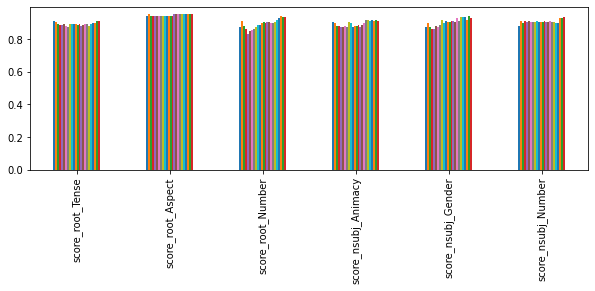

In [ ]:
temp.T.plot.bar(figsize=(10, 3), legend=False)